In [35]:
import asyncio
from dotenv import load_dotenv
load_dotenv()
import nest_asyncio
nest_asyncio.apply()
import aiohttp
import os
import json
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

import cv2
import numpy as np

from anthropic import AsyncAnthropic
from openai import AsyncOpenAI

from transparent_background import Remover
lyrics="""
Verse 1:
When yer sailin' on the seas (yo-ho!)
And you've got some tasty treats (arr!)
Don't forget to share with mates
That's what every pirate states! (ahoy!)

Chorus:
Sharin' is carin', me hearties know
It fills our hearts with a friendly glow
Whether it's treasure or a yummy snack
Sharin' with others keeps the smiles on track! (yo-ho!)

Verse 2:
If you've got a shiny coin (avast!)
Or a scrumptious candy growin'
Pass it 'round to all yer crew
Sharin' makes the skies more blue! (arr!)

Chorus:
Sharin' is carin', me hearties know
It fills our hearts with a friendly glow

Whether it's treasure or a yummy snack
Sharin' with others keeps the smiles on track! (yo-ho!)
"""
prompt = """
You are given lyrics from a song that I created.
You are in charge of making a list of pictures relating to the song
The pictures should be relevant to the text and be of individual items only.
Each description should start with: a clipart of...
End with: on a white background
Please give me 5 descriptions.

Return a valid json object with the list of descriptions.
Example output
["a clipart of a microphone on a white background", "a clipart of a guitar on a white background"]
"""
async def generate_text(text, script):
    client = AsyncAnthropic(
        # This is the default and can be omitted
        api_key=os.environ.get("ANTHROPIC_API_KEY"),
    )

    message = await client.messages.create(
        temperature=0.5,
        max_tokens=1024,
        messages=[
            {
                "role": "user",
                "content": text + script,
            },
            {"role": "assistant", "content": "["},
        ],
        model="claude-3-opus-20240229",
    )

    return message.content

/Users/artemis/miniconda3/envs/abseas/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
pictures = asyncio.run(generate_text(lyrics, prompt))

In [15]:
pictures[0].text

'\n  "a clipart of a pirate ship on a white background",\n  "a clipart of a treasure chest on a white background",\n  "a clipart of a pirate hat on a white background",\n  "a clipart of a candy on a white background",\n  "a clipart of a gold coin on a white background"\n]'

In [16]:
pictures = json.loads("["+pictures[0].text)

In [17]:
pictures

['a clipart of a pirate ship on a white background',
 'a clipart of a treasure chest on a white background',
 'a clipart of a pirate hat on a white background',
 'a clipart of a candy on a white background',
 'a clipart of a gold coin on a white background']

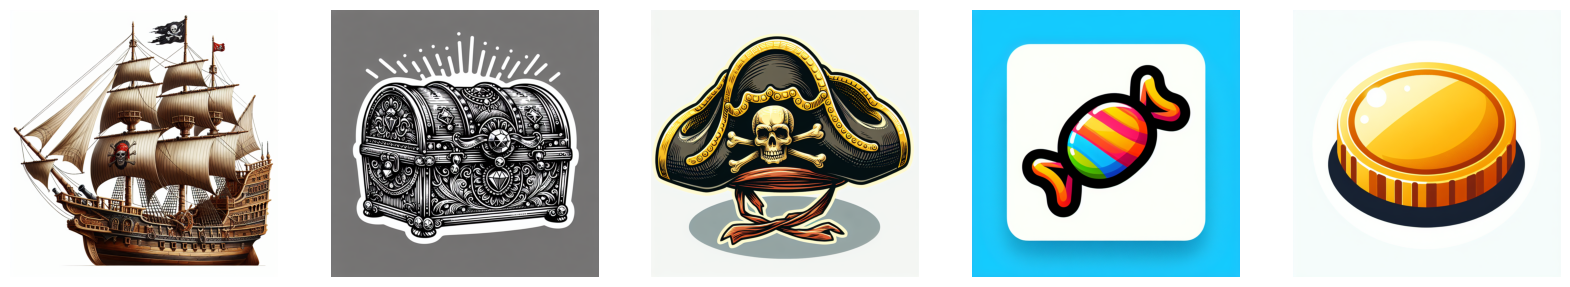

In [31]:
async def fetch_image_binary(url):
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as response:
            # Make sure the request was successful
            if response.status == 200:
                # Read and return the binary content of the image
                return await response.read()
            else:
                # Handle possible HTTP errors (e.g., 404 Not Found) here if needed
                return None


async def generate_image(description):
    client = AsyncOpenAI()
    response = await client.images.generate(
        model="dall-e-3",
        prompt=description,
        size="1024x1024",
        quality="standard",
        n=1,
    )
    image_binary = await fetch_image_binary(response.data[0].url)
    return image_binary


async def generate_images(pictures):
    tasks = [generate_image(picture) for picture in pictures]
    imgs = await asyncio.gather(*tasks)
    return imgs

imgs = asyncio.run(generate_images(pictures))

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(1, len(imgs), figsize=(20, 5))  # Adjust figsize as needed

for ax, img in zip(axes, imgs):
    image = Image.open(BytesIO(img))
    ax.imshow(image)
    ax.axis("off")  # Hide axes ticks

plt.show()

In [36]:
remover = Remover()

/Users/artemis/miniconda3/envs/abseas/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Settings -> Mode=base, Device=mps:0, Torchscript=disabled


In [39]:
def display_on_solid_background(pil_img, background_color=(255, 0, 0)):
    """
    Paste the PIL Image on a solid background color to visualize transparency.
    
    Args:
    - pil_img: A PIL Image object, expected to have an alpha channel.
    - background_color: A tuple representing the RGB color of the background.
    
    Returns:
    - A PIL Image object with the original image pasted on a solid background.
    """
    # Create a background image of the same size as the input image, filled with the background_color
    background = Image.new("RGB", pil_img.size, background_color)
    # Convert the input image to RGBA if not already in that mode
    pil_img_rgba = pil_img.convert("RGBA")
    # Paste the input image onto the background, using its alpha channel as a mask
    background.paste(pil_img_rgba, (0, 0), pil_img_rgba)
    return background

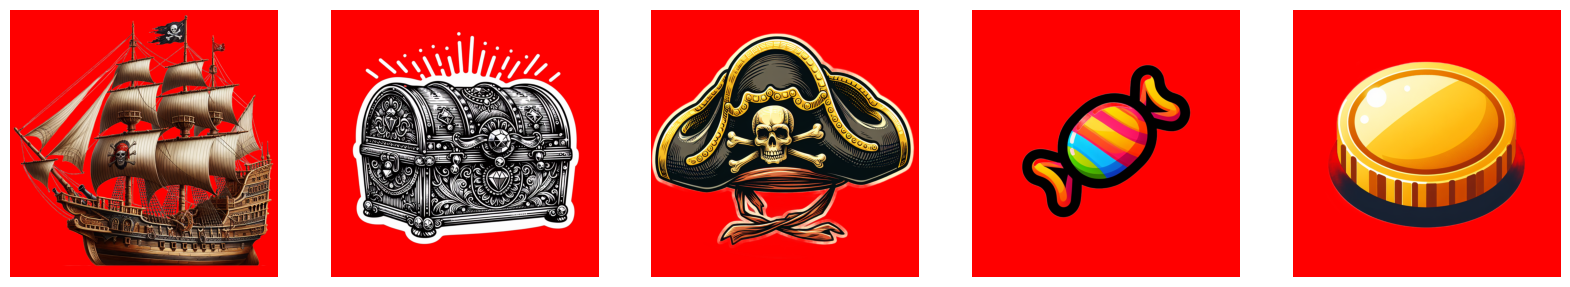

In [41]:
# Assuming `imgs` is a list of binary data for each image
removed_background_images = [remover.process(Image.open(BytesIO(img))) for img in imgs]

fig, axes = plt.subplots(1, len(removed_background_images), figsize=(20, 5))
for ax, img in zip(axes, removed_background_images):
    # Display each image on a red background
    img_on_bg = display_on_solid_background(img, background_color=(255, 0, 0))
    ax.imshow(img_on_bg)
    ax.axis("off")
plt.show()